In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Q1. Pricing American Options using Trinomial Tree

**Function takes input:**

a. Spot price  
b. Strike price  
c. Time to maturity (in fraction of years)  
d. Risk free rate  
e. Dividend yield  
f. Stock return volatility  
g. Call or Put  
h. Choice of trinomial schema: CRR or JR  
i. Number of time steps

In [ ]:
def trinomial_tree(S0, K, T, n, r, q, sigma, is_call, schema):
     
    dt = T/n 
    df = np.exp(-r*dt)

    # --- Cox-Ross-Rubenstein ---
    if schema.lower() == 'crr':
        # Movement factors
        u = np.exp(sigma * np.sqrt(2*dt))
        d = 1/u
        m = 1.0

        # Transition probabilities 
        num_pu = ((np.exp((r-q)*dt/2)) - np.exp(-sigma*np.sqrt(dt/2)))
        den = (np.exp(sigma*np.sqrt(dt/2)) - np.exp(-sigma*np.sqrt(dt/2)))
        pu = (num_pu/den)**2
        
        num_pd = ((- np.exp((r-q)*dt/2)) + np.exp(sigma*np.sqrt(dt/2)))
        pd = (num_pd/den)**2

        pm = 1-pu-pd

    # --- Jarrow-Rudd --- 
    elif schema.lower() == 'jr':
        # Movement factors 
        u = np.exp((r-q-((sigma**2)/2))*dt + sigma*np.sqrt(2*dt))
        d = np.exp((r-q-((sigma**2)/2))*dt - sigma*np.sqrt(2*dt))
        m = np.exp((r-q-((sigma**2)/2))*dt)
 
        # Transition probabilities
        pu = pd = 1/4
        pm = 1/2
    
    else:
        raise ValueError("Incorrect schema - must be 'JR' or 'CRR'")
    
    # Sanity check 
    # print(f"u={u:.6f}, d={d:.6f}\n")
    # print(f"pu={pu:.6f}, pm={pm:.6f}, pd={pd:.6f}, sum={pd+pu+pm:.6f}\n")

    # --- Build stock price lattice ---
    stock_tree=[]    
    for i in range(n+1): # n+1 levels (0, 1, ..., n) - For n steps, there are n+1 levels in the tree
        level= [S0*(u**(i-j)) for j in range(2*i+1)]
        stock_tree.append(level)

    # --- Initialise option tree ---
    option_tree = [None]*(n+1)
    option_tree[-1]=[max(S-K,0) if is_call else max(K-S,0) for S in stock_tree[-1]]
    
    # --- Initialise early exercise boundary ---
    exercise_flag=[None]*(n+1)
    exercise_flag[-1]=[0]*len(stock_tree[-1]) # no early exercise at maturity, set all flags to 0

    # --- Backward Induction ---
    for i in range(n-1,-1,-1):
        level_payoffs=[]
        level_flags=[]
        for j in range(2*i+1):
            V = df*(pu*option_tree[i+1][j] 
                         + pm*option_tree[i+1][j+1] 
                         + pd*option_tree[i+1][j+2]) # continuous discounted value of option
            S = stock_tree[i][j]
            # if option is exercised now 
            V_ex = max(S-K,0) if is_call else max(K-S,0)

            if V_ex>V:
                V, flag=V_ex,1
            else:
                flag=0

            level_payoffs.append(V)
            level_flags.append(flag)

        option_tree[i]=level_payoffs
        exercise_flag[i]=level_flags
    
    # --- Early Exercise Boundary --- 
    boundary_prices=[]
    for i in range(n+1):
        flags=exercise_flag[i]
        exercised_nodes=[stock_tree[i][j] for j, f in enumerate(flags) if f==1]
        if exercised_nodes:
            if is_call:
                boundary=min(exercised_nodes)
            else:
                boundary=max(exercised_nodes)
            boundary_prices.append(boundary)
        else:
            boundary_prices.append(np.nan)

    return option_tree[0][0], stock_tree, option_tree, exercise_flag, boundary_prices

### Q2. Use above pricer

#### Part a. American Call

For an American call option on a dividend-paying stock, the early exercise is optimal only when the stock price is high, particularly near maturity.  
This is because, exercising early allows the holder to own the stock and collect the dividends, while holding the option forfeits that income.  

In this case, high dividend yield (q=0.2) encourages early exercise, while the absence of risk-free rate removes the incentive to delay exercise for time-value benefits.  
On the other hand, volatility (sigma=0.3) increases the value of waiting, and thus oppose early exercise.  

The result is an early exercise boundary that rises sharply as maturity approaches, reflecting that only when the stock price is sufficiently high does it make sense to exercise early. In essence, the trade-off is between collecting dividends now versus keeping the option's flexibility for future gains. As maturity approaches, the dividend motive is more optimal.


In [3]:
call_S0=100
call_K=80
call_T=1
call_n=250
call_r=0
call_q=0.2
call_sigma=0.3

In [4]:
price1, stock_tree1, option_tree1, exercise_flag1, boundary_prices1 = trinomial_tree(S0=call_S0, K=call_K, T=call_T, n=call_n,
                                                               r=call_r, q=call_q, sigma=call_sigma,
                                                               is_call=True, schema='CRR'
                                                            )

print(f"American Call Option Price: ${price1:,.2f}")

American Call Option Price: $20.00


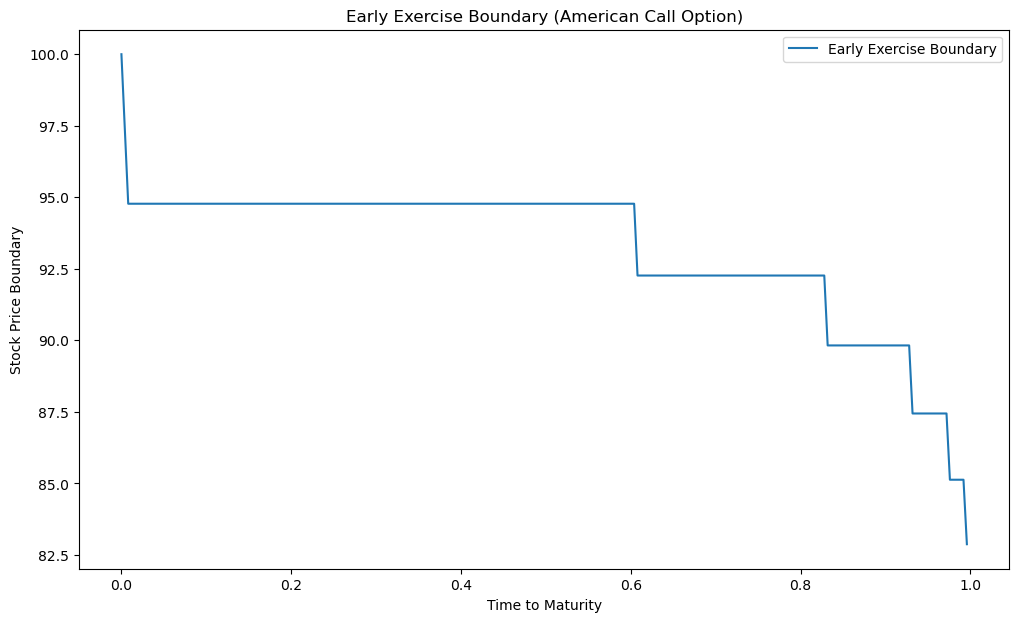

In [5]:
plt.figure(figsize=(12,7))
plt.plot(np.linspace(0, call_T, call_n+1), boundary_prices1, label="Early Exercise Boundary")
plt.xlabel("Time to Maturity")
plt.ylabel("Stock Price Boundary")
plt.title("Early Exercise Boundary (American Call Option)")
plt.legend()
plt.show()

#### Part b. American Put

For American Put option, early exercise can be optimal when the stock price falls sufficiently below the strike, but not always immediately as waiting retains the possibility of greater profit if the stock price drops further.  
Early in the option's life, the "waiting-value" is significant, so the holder prefers to delay exercise unless the stock price is very low.   
As maturity approaches and the opportunity for further decline reduces, the early exercise boundary moves downward toward the strike price, reflecting and increase in the likelihood of exercise.   

In this case, the option's price of $22.93 includes both intrinsic value ($20) and an additional time-value ($2.93) from the benefit of waiting.  
The downward-sloping boundary thus captures the gradual shift from patience to decisiveness as the expiry approaches. Early exercise becomes optimal only when there is little time left and the stock is clealy undervalued. 

In [6]:
put_S0=100
put_K=120
put_T=1
put_n=250
put_r=0.04
put_q=0
put_sigma=0.3

In [7]:
price2, stock_tree2, option_tree2, exercise_flag2, boundary_prices2 = trinomial_tree(S0=put_S0, K=put_K, T=put_T, n=put_n,
                                                                                     r=put_r, q=put_q, sigma=put_sigma,
                                                                                     is_call=False, schema='jr'
                                                                                    )

print(f"American Put Option Price: ${price2:,.2f}")

American Put Option Price: $22.93


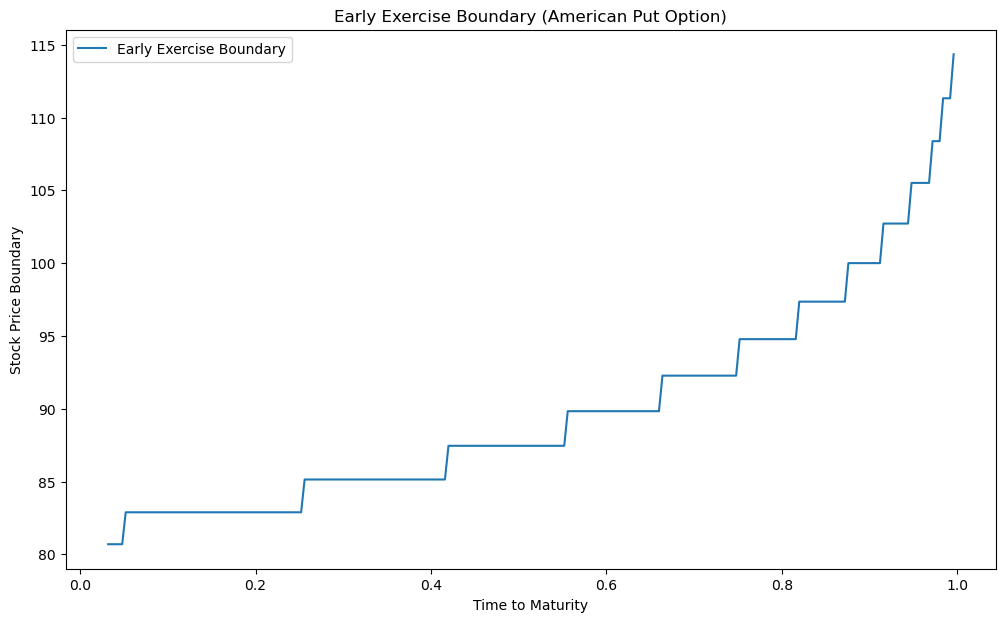

In [8]:
plt.figure(figsize=(12,7))
plt.plot(np.linspace(0, put_T, put_n+1), boundary_prices2, label="Early Exercise Boundary")
plt.xlabel("Time to Maturity")
plt.ylabel("Stock Price Boundary")
plt.title("Early Exercise Boundary (American Put Option)")
plt.legend()
plt.show()

#### Part c.
##### Part i. Changing stock price vs option price
As stock price increases, put option price decreases as option becomes less likely to be in-the-money.

In [9]:
S_values=np.linspace(50,160,30)
prices=[]

for S in S_values:
    price,_,_,_,_=trinomial_tree(S0=S
                                 , K=put_K
                                 , T=put_T
                                 , n=put_n  
                                 , r=put_r
                                 , q=put_q
                                 , sigma=put_sigma
                                 , is_call=False
                                 , schema='jr')
    prices.append(price)

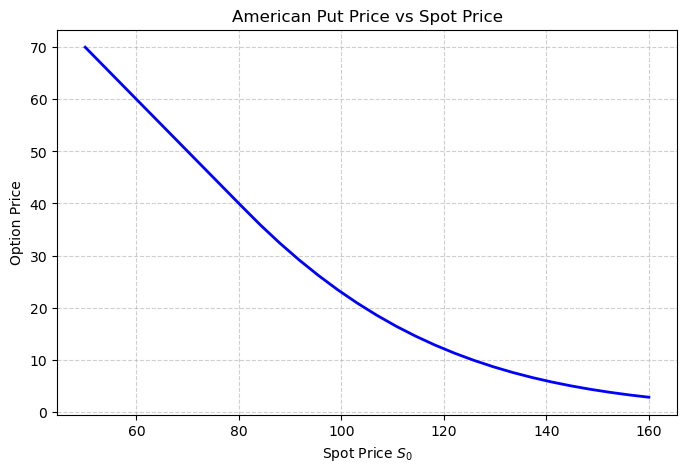

In [10]:
plt.figure(figsize=(8,5))
plt.plot(S_values,prices,'b-',lw=2)
plt.xlabel("Spot Price $S_0$")
plt.ylabel("Option Price")
plt.title("American Put Price vs Spot Price")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

##### Part ii. Changing time to maturity vs option price
For longer maturities, put option price is higher giving more time for price to move favourably.

In [11]:
T_values=np.linspace(0.25,2.0,50)
prices=[]

for T in T_values:
    price,_,_,_,_=trinomial_tree(S0=put_S0
                                 , K=put_K
                                 , T=T
                                 , n=put_n  
                                 , r=put_r
                                 , q=put_q
                                 , sigma=put_sigma
                                 , is_call=False
                                 , schema='jr')
    prices.append(price)

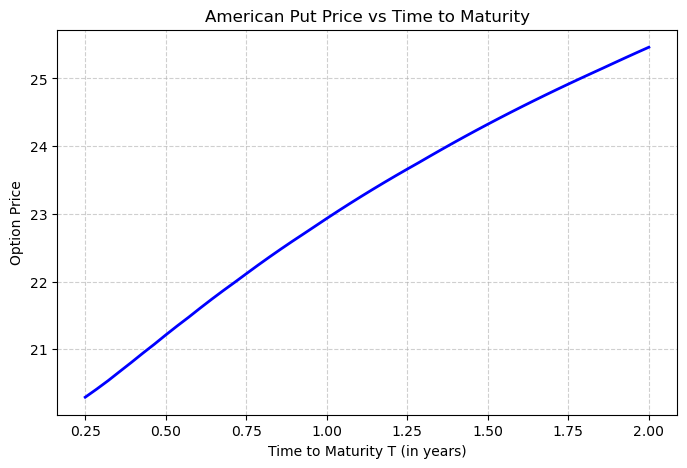

In [12]:
plt.figure(figsize=(8,5))
plt.plot(T_values,prices,'b-',lw=2)
plt.xlabel("Time to Maturity T (in years)")
plt.ylabel("Option Price")
plt.title("American Put Price vs Time to Maturity")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

##### Part iii. Changing volatility vs option price
For higher volatilities, put option price is higher as more uncertainty increases value. 

In [13]:
sigma_values=np.linspace(0.15,1.5,50)
prices=[]

for sigma in sigma_values:
    price,_,_,_,_=trinomial_tree(S0=put_S0
                                , K=put_K
                                , T=put_T
                                , n=put_n  
                                , r=put_r
                                , q=put_q
                                , sigma=sigma
                                , is_call=False
                                , schema='jr')
    
    prices.append(price)

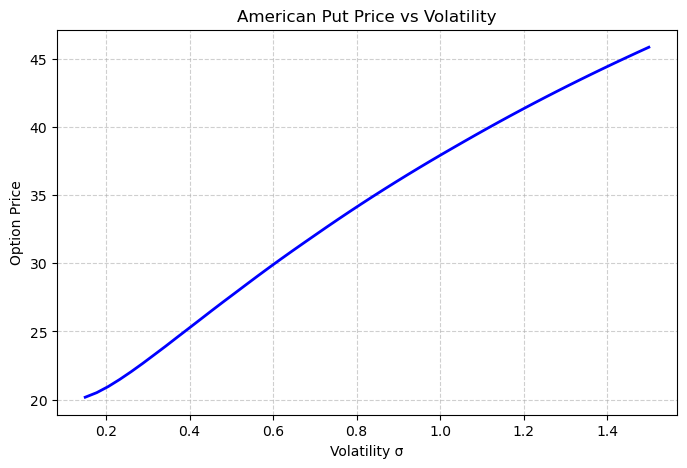

In [14]:
plt.figure(figsize=(8,5))
plt.plot(sigma_values,prices,'b-',lw=2)
plt.xlabel("Volatility σ")
plt.ylabel("Option Price")
plt.title("American Put Price vs Volatility")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()